# Example Use Case: Matplotlib

This notebook shows an example use case for generating *Matplotlib* visualizations of data generated through *imglib2*.

## Import Python Packages

In [1]:
%matplotlib inline

import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import skimage.io as io

# Add Fiji Jars to Classpath

In [2]:
import scyjava_config

scyjava_config.add_endpoints(
    'net.imglib2:imglib2-realtransform:2.2.1',
    'sc.fiji:z_spacing:1.1.1')

import imglyb
import imglyb.util as util

from jnius import autoclass

## Make Sure All Required Jars Are On Classpath

In [3]:
import jnius_config

# export CLASSPATH=`ls -1 /path/to/Fiji.app/jars/*jar /path/to/Fiji.app/plugins/*jar | tr '\\n' ':'`
def check_classpath_for_jar( jar_name ):
    cp = jnius_config.get_classpath()
    realtransform_jar = [ jar for jar in cp if jar_name in jar ]
    if len( realtransform_jar ) == 0:
        raise Exception( "{} not in classpath!\n".format( jar_name ) + \
                        "export CLASSPATH=`ls -1 /path/to/Fiji.app/jars/*jar /path/to/Fiji.app/plugins/*jar | tr '\\n' ':'`\n" + \
                        "and restart kernel!" )
        
check_classpath_for_jar( 'imglib2-realtransform' )
check_classpath_for_jar( 'z_spacing')

## Import Relevant Java Classes

In [4]:
LutRealTransform           = autoclass( 'org.janelia.thickness.lut.LUTRealTransform' )
NLinearInterpolatorFactory = autoclass( 'net.imglib2.interpolation.randomaccess.NLinearInterpolatorFactory' )
RealViews                  = autoclass( 'net.imglib2.realtransform.RealViews' )

## Define Method to Read Data

In [5]:
def read_data( base_dir, iteration ):
    lut_pattern    = '{}/lut/%04d.csv'.format( base_dir )
    shift_url      = '{}/average-shifts/shift'.format( base_dir )
    matrix_path    = 'https://github.com/hanslovsky/imglyb-learnathon/blob/master/notebooks/matplotlib/data/matrix.tif?raw=true'
    
    lut    = np.genfromtxt( lut_pattern % iteration, delimiter=',' )
    shifts = np.genfromtxt( shift_url )
    matrix = io.imread( matrix_path )
    return lut, shifts, matrix

## Create Plots
See (https://matplotlib.org) for reference

In [6]:
def make_plots( iteration, lut, shift, matrix ):
    nRows = 5
    nCols = 2 * ( nRows - 1 )

    fig = plt.figure( figsize=( 12, 8 ) )

    ax1 = plt.subplot2grid( ( nRows, nCols ), ( 0, 0 ), rowspan = nRows - 1, colspan = nCols // 2 )
    ax2 = plt.subplot2grid( ( nRows, nCols ), ( 0, nCols // 2 ), rowspan = nRows - 1, colspan = nCols // 2 )
    ax3 = plt.subplot2grid( ( nRows, nCols ), ( nRows - 1, 0 ), colspan = nCols )

    ax1.set_aspect( 'equal' )
    ax2.set_aspect( 'equal' )
    ax1.set_xlim( lut[ 0, 0 ], lut[ -1, 0 ] )
    ax1.set_ylim( lut[ 0, 1 ], lut[ -1, 1 ] )

    for ax in [ ax1, ax2, ax3 ]:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    source       = imglyb.to_imglib( matrix )
    extended     = util.Views.extendBorder( source )
    interpolated = util.Views.interpolate( extended, NLinearInterpolatorFactory() )
    transform    = LutRealTransform( lut[:, 1].tolist(), 2, 2 )
    transformed  = RealViews.transformReal( interpolated, transform )
    target       = np.empty( matrix.shape, dtype=matrix.dtype )
    
    util.Helpers.burnIn( util.Views.interval( util.Views.raster( transformed ), source ), imglyb.to_imglib( target ) )
    
    plt.tight_layout(pad=0.0, w_pad=0.5, h_pad=0.5)

    ax1.plot( *( lut.T ) )
    ax2.imshow( target[ ::-1, ... ], cmap='viridis' )
    ax3.plot( shift )
    ax3.plot( [ iteration ], [ shift[ iteration ] ], 'd', color='red', markersize=20 )

## Visualize Data at Different Stages of Optimization

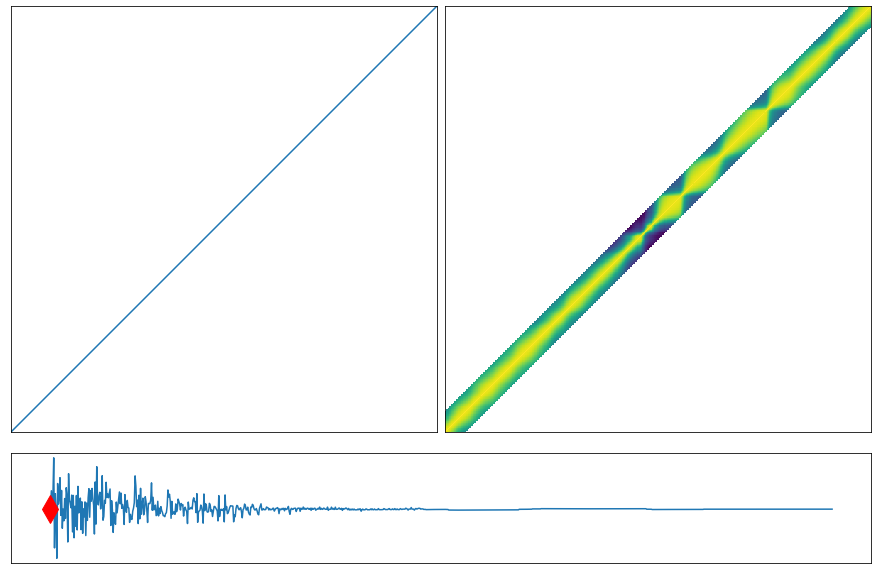

In [7]:
base_dir = 'https://raw.githubusercontent.com/hanslovsky/imglyb-learnathon/master/notebooks/matplotlib/data'
iteration = 0
make_plots( iteration, *read_data( base_dir, iteration ) )

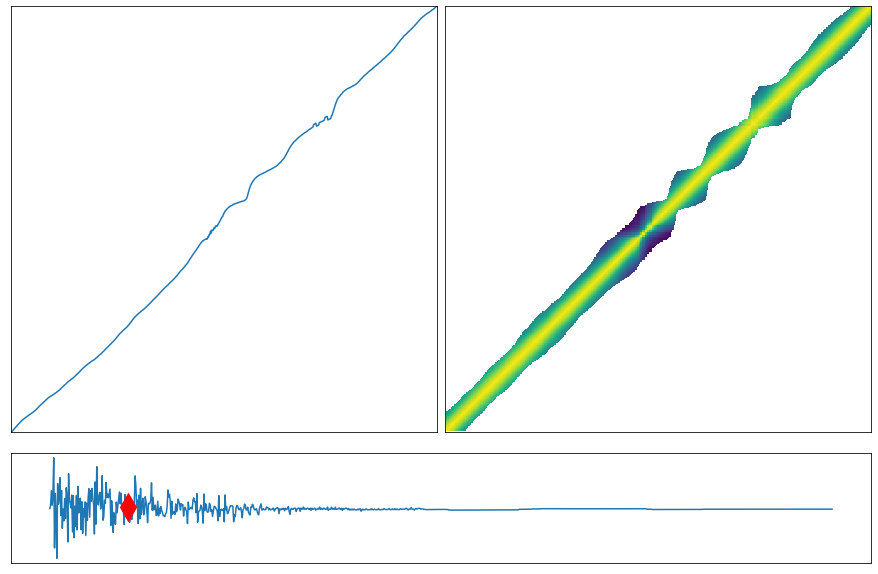

In [8]:
# base_dir = '/home/phil/z-spacing-gridsearch/3.0-1.0'
iteration = 100
make_plots( iteration, *read_data( base_dir, iteration ) )

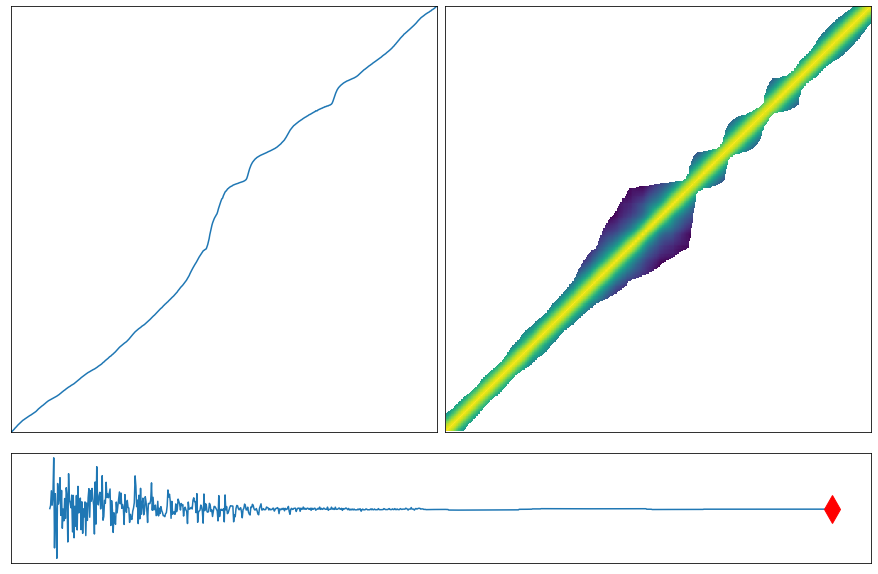

In [9]:
# base_dir = '/home/phil/z-spacing-gridsearch/3.0-1.0'
iteration = 1000
make_plots( iteration, *read_data( base_dir, iteration ) )